In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import scipy.stats as stats
import re
from scipy.interpolate import interp1d, splev, splrep

In [6]:
profession_frequency_df = pd.read_csv("../data/analysis_data/top500_merged_profession_frequency.csv", index_col=0)
mentions_df = pd.read_csv('../data/mentions/mentions.word_filtered.sense_filtered.soc_mapped.merged.sentiment_added.csv', index_col=None, dtype={'soc_name':str, 'soc_code':str})
imdb_df = pd.read_csv('../data/imdb/imdb.ngram.box_office.csv', index_col=None)

In [4]:
def find_frequecy_by_individual_profession(profession):
    years = np.arange(1950, 2018)
    df = mentions_df[mentions_df.profession_merge == profession]
    df = df.groupby('year').agg({'imdb':len}).imdb
    df = df.reindex(index=years).fillna(0)
    n = len(profession.split())
    ngram_count = imdb_df.groupby('year').agg({f'{n}_gram_count':sum}).loc[years, f'{n}_gram_count']
    return df/ngram_count

In [8]:
mentions_df = mentions_df.merge(imdb_df[['imdb_ID','year']], left_on='imdb', right_on='imdb_ID', how="left")
profession_df = mentions_df[(mentions_df.profession_merge == 'scientist') & (mentions_df.year >= 1960) & (mentions_df.year <= 1975)]
imdb_df.index = imdb_df.imdb_ID

In [9]:
find_frequecy_by_individual_profession('air marshal')

year
1950    0.000000e+00
1951    0.000000e+00
1952    0.000000e+00
1953    0.000000e+00
1954    0.000000e+00
            ...     
2013    4.007970e-07
2014    6.740942e-07
2015    7.848830e-07
2016    1.245234e-07
2017    4.246802e-07
Length: 68, dtype: float64

In [3]:
profession_frequency_df.index = profession_frequency_df.profession_merge

In [10]:
def plot_trend(*items, df=profession_frequency_df, min_year=1950, max_year=2017, xticks=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2017], smooth=5, xlabel="year", ylabel="frequency", legend=True, tikz_save=False, interpolate=False):
    plt.close("all")
    years = np.arange(min_year, max_year + 1).astype(str)
    for item in items:
        if False:
            freq = df.loc[item, years]
        else:
            freq = find_frequecy_by_individual_profession(item)
        
        corr, pval = stats.spearmanr(freq.values, years.astype(int))   
        print(f"{item:50s}: corr = {corr:5.2f} {pval:.2e} {'sig' if pval < 0.05 else ''}")
        
        x = years.astype(int)
        y = freq.rolling(window=smooth, min_periods=1).mean()
        if interpolate:
#             f = interp1d(x, y, kind='quadratic')
#             xnew = np.linspace(1950, 2017, num=1000, endpoint=True)
#             plt.plot(xnew, f(xnew), label=item, lw=4)
            spline = splrep(x, y)
            xnew = np.linspace(1950, 2017, num=1000, endpoint=True)
            plt.plot(xnew, splev(xnew, spline), label=item, lw=4)
        else:
            plt.plot(x, y, label=item, lw=4)
    
    plt.xticks(ticks=xticks, labels=np.array(xticks).astype(str))
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if legend:
        plt.legend(prop={"size":12})
    if tikz_save:
        filename = f"data/analysis_data/trend/" + ".".join(list(items)) + ".tex"
        tikzplotlib.save(filename)
    else:
        plt.show()

In [11]:
def examine_trend(profession, min_year, max_year, d=0):
    profession_df = mentions_df[(mentions_df.profession_merge == profession) & (mentions_df.year >= min_year) & (mentions_df.year <= max_year)]
    year = profession_df.groupby("year").agg(len)['imdb'].idxmax()
    print(f'max-freq year = {year}\n')
    titles = []
    for imdb in profession_df[(profession_df.year >= year-d) & (profession_df.year <= year+d)].imdb.unique():
        title = imdb_df.loc[imdb, 'imdb_title']
        if pd.notna(title):
            titles.append(title)
    print("\n".join(sorted(titles)))

In [12]:
examine_trend('basketball player', 1990, 2005, d=2)

max-freq year = 2002

A Sigh
Air Bud 3
Air Bud: Seventh Inning Fetch
Back in the Ring
Bedazzled
Big Shot: Confessions of a Campus Bookie
Blackmail Boy
Blizzard of '01
Bring It On: Again
Broken Wings
Che goh ha tin yau yee sing
Cheerleader Queens
Conman in Tokyo
Dead Dogs and Gym Teachers
Delayed Reaction
Double Date
Even the Score
Exposure
Fantasy Camp: Part 1
Finding Forrester
Freddy Got Fingered
Frequency
Full-Court Miracle
G.O.R.A.
Going to the Mat
Gran Turismo Concept: 2002 Tokyo-Geneva
Harvard Man
Hell Up in Hollywood: Soul Cinema and the 1970s
Himalaya with Michael Palin
It's Supposed to Be Fun
Juwanna Mann
Keg! Max!
Legion
Let the Reigns Go Loose
Like Mike
Love & Sex
Lucky Strike
Michael Jordan to the Max
Mind Games
National Geographic: The Incredible Human Body
O'Dweeds & Trading Spouses
Once Upon a Time in High School: The Spirit of Jeet Kune Do
One
Party Lines
People of Rome
Rapture
Roger Dodger
Sanctuary
Something Old, Something New
Son-in-Law
Strange Attractors
The 16th Ann

geologist                                         : corr =  0.17 1.58e-01 
archaeologist                                     : corr =  0.52 4.81e-06 sig


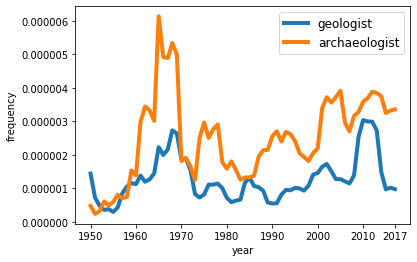

In [13]:
plot_trend('geologist', 'archaeologist')

geologist                                         : corr =  0.17 1.58e-01 
archaeologist                                     : corr =  0.52 4.81e-06 sig


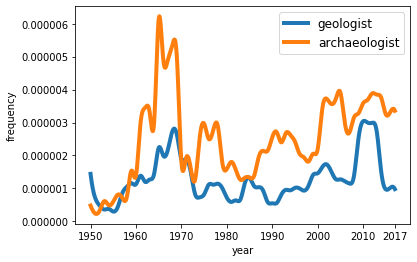

In [29]:
plot_trend('geologist','archaeologist', interpolate=True)

In [14]:
profession_frequency_df.head()

1950          1951      1952          1953      1954  \
profession_merge                                                             
accountant        0.000014  2.912382e-06  0.000008  2.953883e-06  0.000004   
acrobat           0.000005  4.853971e-07  0.000002  9.846275e-07  0.000002   
actor             0.000030  2.329906e-05  0.000041  3.544659e-05  0.000033   
actress           0.000024  1.601810e-05  0.000016  4.676981e-05  0.000019   
administrator     0.000005  9.707941e-07  0.000006  4.923138e-07  0.000001   

                          1955      1956          1957      1958  \
profession_merge                                                   
accountant        2.389870e-06  0.000012  1.118629e-05  0.000005   
acrobat           6.828201e-07  0.000001  6.292289e-06  0.000003   
actor             1.707050e-05  0.000021  3.950159e-05  0.000029   
actress           1.024230e-05  0.000016  1.398287e-05  0.000014   
administrator     2.048460e-06  0.000004  6.991433e-07  0.000001   

                          1959  ...          2008          2009          2010  \
profession_merge                ...                                             
accountant        1.126231e-05  ...  5.670011e-06  5.475462e-06  4.684715e-06   
acrobat           6.624888e-07  ...  8.015198e-07  3.716377e-07  6.417418e-07   
actor             1.755595e-05  ...  2.977498e-05  3.017698e-05  2.708150e-05   
actress           1.258729e-05  ...  1.175562e-05  1.283389e-05  1.050317e-05   
administrator     1.656222e-06  ...  2.048329e-06  2.130723e-06  1.946617e-06   

                          2011          2012          2013          2014  \
profession_merge                                                           
accountant        6.246820e-06  5.750266e-06  5.348605e-06  4.947257e-06   
acrobat           4.656015e-07  5.124000e-07  3.650925e-07  6.184072e-07   
actor             2.692729e-05  2.856155e-05  2.893358e-05  2.731905e-05   
actress           1.247424e-05  1.254431e-05  1.186551e-05  1.098582e-05   
administrator     1.998206e-06  2.125511e-06  1.898481e-06  1.818845e-06   

                          2015          2016          2017  
profession_merge                                            
accountant        4.641961e-06  6.724351e-06  4.120042e-06  
acrobat           7.320016e-07  4.854478e-07  7.704143e-07  
actor             2.754826e-05  3.315429e-05  2.003077e-05  
actress           8.569775e-06  1.181256e-05  8.575046e-06  
administrator     1.874638e-06  1.833914e-06  1.574325e-06  

[5 rows x 68 columns]

In [45]:
years = np.arange(1950, 2018).astype(str)

In [50]:
profession_frequency_df['mean_freq'] = profession_frequency_df[years].mean(axis=1)

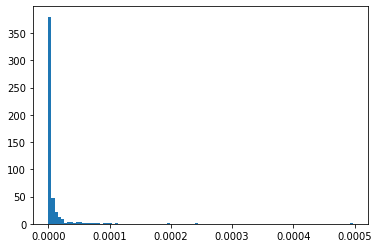

In [52]:
plt.hist(profession_frequency_df.mean_freq, bins=100)
plt.show()

In [58]:
np.quantile(profession_frequency_df.mean_freq, 0.90)

1.5229616896511882e-05

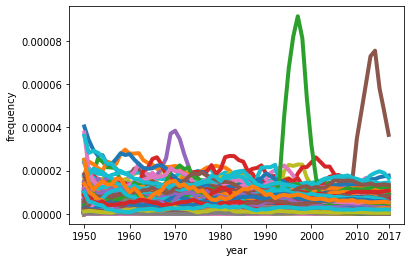

In [59]:
plot_trend(*profession_frequency_df[profession_frequency_df.mean_freq < np.quantile(profession_frequency_df.mean_freq, 0.9)].index, legend=False)

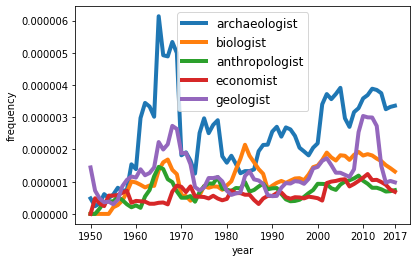

In [62]:
plot_trend('archaeologist','biologist','anthropologist','economist','geologist')

actor                                             : corr = -0.03 7.83e-01 
actress                                           : corr = -0.26 3.39e-02 sig
artist                                            : corr = -0.05 6.78e-01 


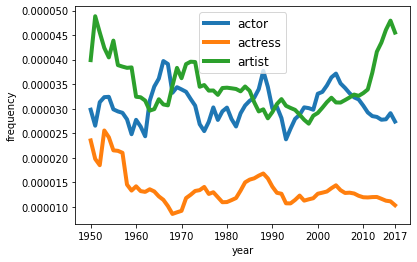

In [72]:
plot_trend('actor','actress','artist')

author                                            : corr =  0.09 4.76e-01 
writer                                            : corr =  0.44 1.94e-04 sig


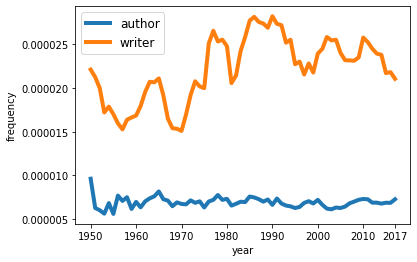

In [73]:
plot_trend('author','writer')

baseball player                                   : corr =  0.46 6.56e-05 sig
basketball player                                 : corr =  0.57 4.99e-07 sig
football player                                   : corr =  0.51 8.16e-06 sig
hockey player                                     : corr =  0.59 9.74e-08 sig


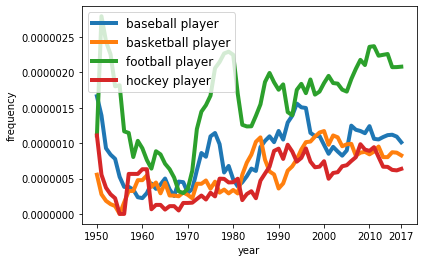

In [88]:
plot_trend('baseball player', 'basketball player', 'football player', 'hockey player')

In [90]:
examine_trend('basketball player', 1980, 1990, d=2)

max-freq year = 1985

A View from the Bench
Basket Case
Big Trouble
Birdman of Budapest
Darwin on the Galapagos
Evils of the Night
Extra Lap
Going Home, Going Home
Gui ma fei ren
Lianna
One Crazy Summer
Strange Invaders
Teen Wolf
The Lonely Guy
This Is Spinal Tap
Top Secret!
When She Was Bad


bass player                                       : corr =  0.80 2.21e-16 sig
pianist                                           : corr = -0.46 7.54e-05 sig
guitarist                                         : corr =  0.58 2.75e-07 sig
drummer                                           : corr =  0.24 4.47e-02 sig


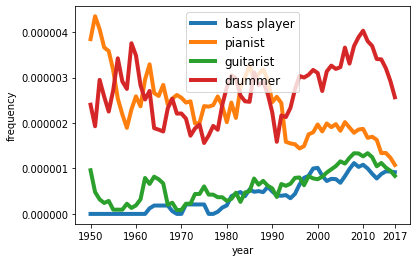

In [97]:
plot_trend('bass player', 'pianist', 'guitarist', 'drummer')

In [96]:
examine_trend('fiddler', 1970, 1985, d=2)

max-freq year = 1977

Brief Re-Encounter
Carry On England
For as Long as the Waters Flow
Gator
No Trespassing
Part II
Part III
Roots
Tatli Nigar
The Breakdown
The Europeans
The Missouri Breaks
The Ritz


boxer                                             : corr =  0.34 4.80e-03 sig
wrestler                                          : corr =  0.07 5.58e-01 


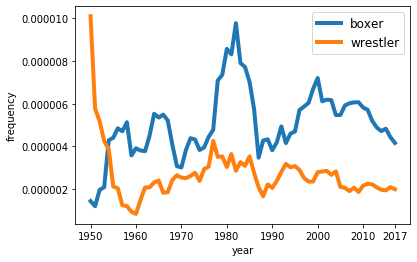

In [98]:
plot_trend('boxer','wrestler')

cameraman                                         : corr =  0.10 4.09e-01 
cinematographer                                   : corr =  0.09 4.82e-01 
choreographer                                     : corr =  0.44 1.90e-04 sig


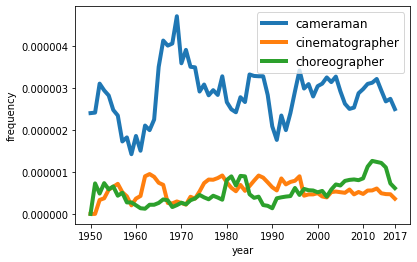

In [99]:
plot_trend('cameraman','cinematographer','choreographer')

designer                                          : corr =  0.59 1.36e-07 sig
decorator                                         : corr = -0.27 2.71e-02 sig


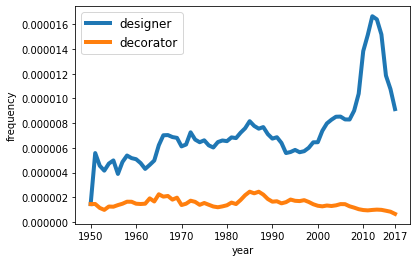

In [100]:
plot_trend('designer','decorator')

film director                                     : corr = -0.02 8.87e-01 
producer                                          : corr =  0.55 9.74e-07 sig


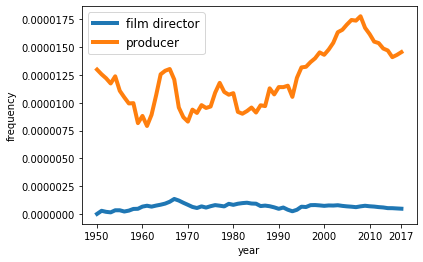

In [101]:
plot_trend('film director','producer')

stripper                                          : corr =  0.77 1.25e-14 sig
porn star                                         : corr =  0.76 5.27e-14 sig


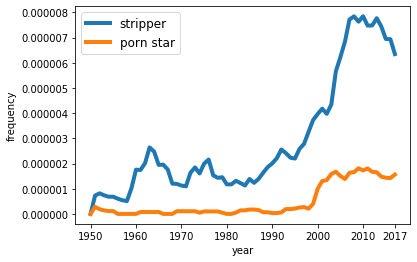

In [103]:
plot_trend('stripper','porn star')

columnist                                         : corr = -0.23 6.45e-02 
correspondent                                     : corr = -0.11 3.79e-01 
journalist                                        : corr =  0.45 1.08e-04 sig
reporter                                          : corr =  0.26 3.10e-02 sig


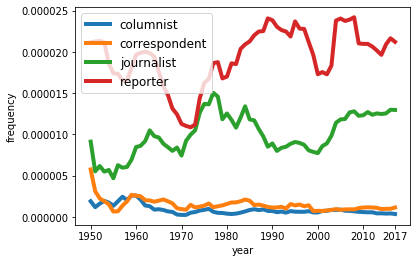

In [112]:
plot_trend('columnist','correspondent','journalist','reporter')

author                                            : corr =  0.09 4.76e-01 
novelist                                          : corr =  0.07 5.53e-01 
writer                                            : corr =  0.44 1.94e-04 sig


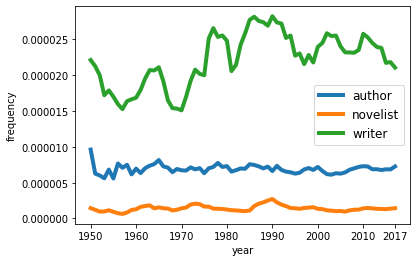

In [108]:
plot_trend('author','novelist','writer')

playwright                                        : corr = -0.21 8.67e-02 
songwriter                                        : corr =  0.31 9.41e-03 sig


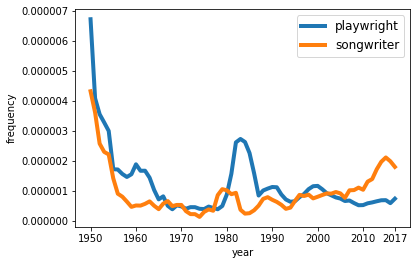

In [110]:
plot_trend('playwright','songwriter')

hacker                                            : corr =  0.88 1.20e-22 sig
programmer                                        : corr =  0.73 1.61e-12 sig


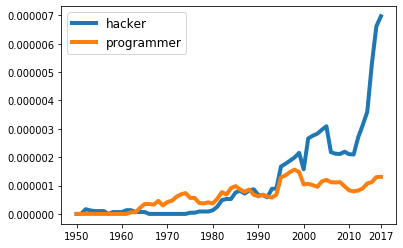

In [120]:
plot_trend("hacker","programmer", ylabel=None, tikz_save=True, xlabel=None)

attorney                                          : corr =  0.19 1.29e-01 
lawyer                                            : corr =  0.30 1.37e-02 sig


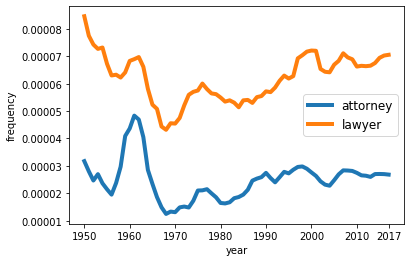

In [178]:
plot_trend('attorney','lawyer')

defense attorney                                  : corr =  0.58 2.71e-07 sig
prosecutor                                        : corr =  0.29 1.55e-02 sig


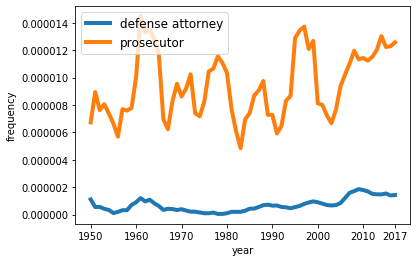

In [179]:
plot_trend('defense attorney','prosecutor')

waiter                                            : corr = -0.88 5.23e-23 sig
waitress                                          : corr =  0.54 1.76e-06 sig


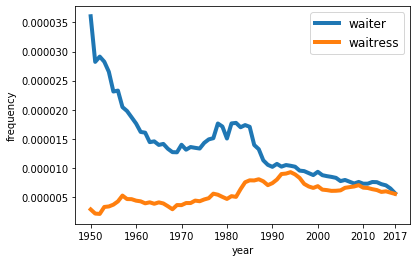

In [185]:
plot_trend('waiter','waitress')

barman                                            : corr = -0.22 7.76e-02 
barmaid                                           : corr = -0.35 3.56e-03 sig
bartender                                         : corr = -0.12 3.39e-01 


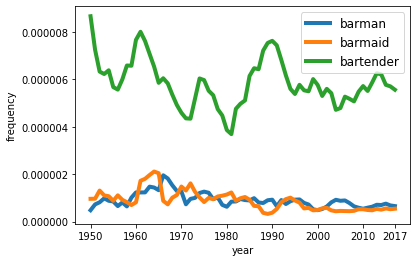

In [190]:
plot_trend('barman','barmaid','bartender')

barman                                            : corr = -0.22 7.76e-02 
barmaid                                           : corr = -0.35 3.56e-03 sig


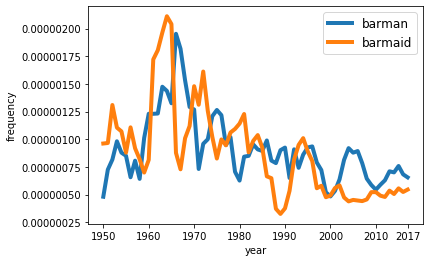

In [191]:
plot_trend('barman','barmaid')

cook                                              : corr = -0.73 1.01e-12 sig
chef                                              : corr =  0.73 2.39e-12 sig


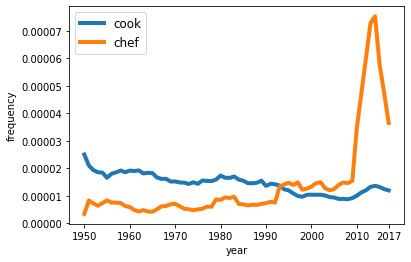

In [187]:
plot_trend('cook','chef')

masseur                                           : corr = -0.41 4.35e-04 sig
masseuse                                          : corr =  0.54 2.20e-06 sig


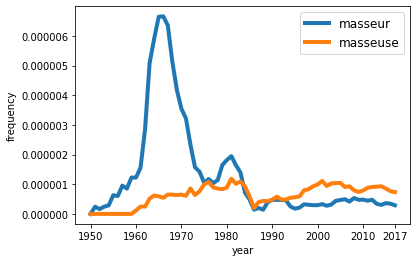

In [195]:
plot_trend('masseur','masseuse')

accountant                                        : corr = -0.22 6.91e-02 
auditor                                           : corr =  0.02 8.54e-01 


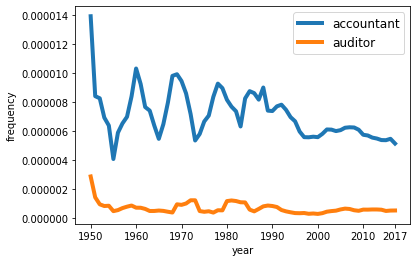

In [196]:
plot_trend('accountant','auditor')

barber                                            : corr = -0.74 9.37e-13 sig
hairdresser                                       : corr = -0.54 1.77e-06 sig


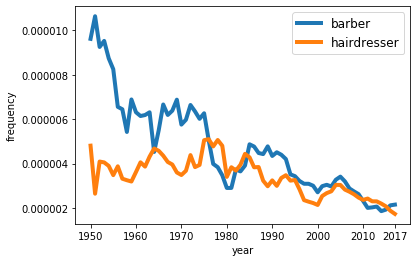

In [198]:
plot_trend('barber','hairdresser')

nanny                                             : corr =  0.39 9.03e-04 sig
babysitter                                        : corr =  0.72 2.92e-12 sig
governess                                         : corr = -0.69 9.56e-11 sig


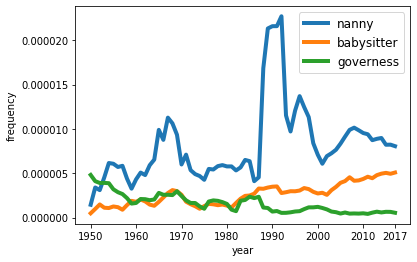

In [200]:
plot_trend('nanny','babysitter','governess')

butler                                            : corr = -0.45 1.00e-04 sig
maid                                              : corr = -0.92 2.91e-28 sig


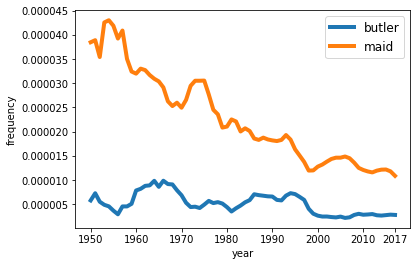

In [202]:
plot_trend('butler','maid')

66861

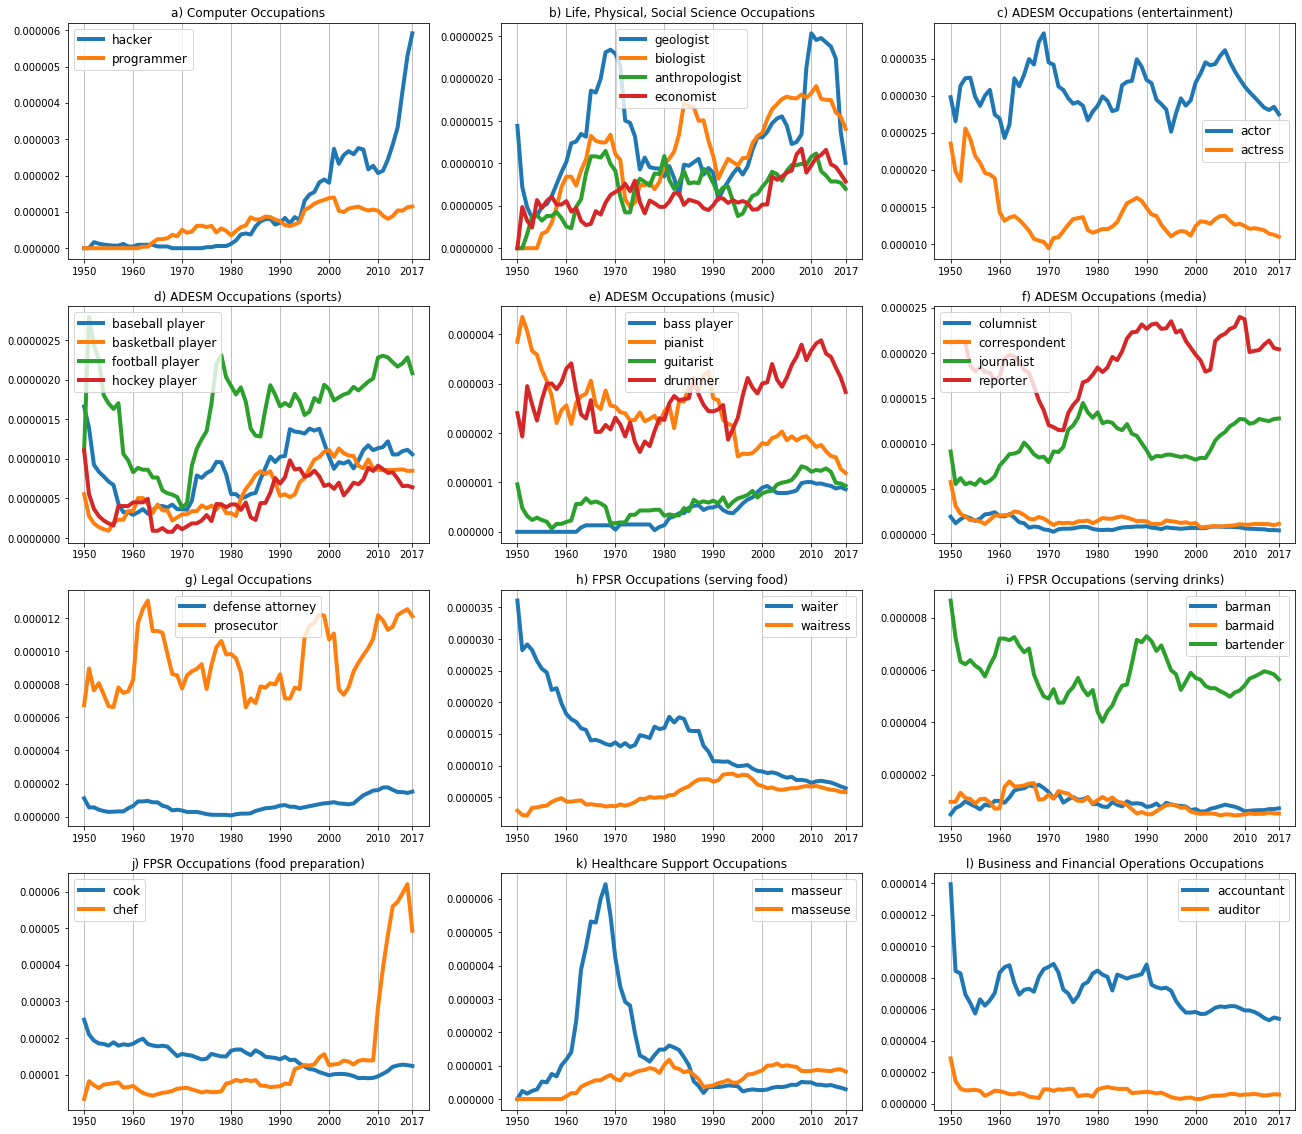

In [76]:
plt.close('all')
years = np.arange(1950, 2018).astype(str)

def helper_plot(*professions):
    for profession in professions:
        freq = profession_frequency_df.loc[profession, years].rolling(window=7, min_periods=1).mean()
        plt.plot(years.astype(int), freq, lw=4, label=profession)
    plt.xticks(ticks=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2017], labels=['1950','1960','1970','1980','1990','2000','2010','2017'])
    plt.grid(axis='x')
    plt.legend(prop={"size":12})

plt.figure(figsize=(22,20))
    
plt.subplot(4,3,1)
helper_plot('hacker','programmer')
plt.title('a) Computer Occupations')

plt.subplot(4,3,2)
helper_plot('geologist','biologist','anthropologist','economist')
plt.title('b) Life, Physical, Social Science Occupations')

plt.subplot(4,3,3)
helper_plot('actor','actress')
plt.title('c) ADESM Occupations (entertainment)')

plt.subplot(4,3,4)
helper_plot('baseball player', 'basketball player', 'football player', 'hockey player')
plt.title('d) ADESM Occupations (sports)')

plt.subplot(4,3,5)
helper_plot('bass player', 'pianist', 'guitarist', 'drummer')
plt.title('e) ADESM Occupations (music)')

plt.subplot(4,3,6)
helper_plot('columnist','correspondent','journalist','reporter')
plt.title('f) ADESM Occupations (media)')

plt.subplot(4,3,7)
helper_plot('defense attorney','prosecutor')
plt.title('g) Legal Occupations')

plt.subplot(4,3,8)
helper_plot('waiter','waitress')
plt.title('h) FPSR Occupations (serving food)')

plt.subplot(4,3,9)
helper_plot('barman','barmaid','bartender')
plt.title('i) FPSR Occupations (serving drinks)')

plt.subplot(4,3,10)
helper_plot('cook','chef')
plt.title('j) FPSR Occupations (food preparation)')

plt.subplot(4,3,11)
helper_plot('masseur','masseuse')
plt.title('k) Healthcare Support Occupations')

plt.subplot(4,3,12)
helper_plot('accountant','auditor')
plt.title('l) Business and Financial Operations Occupations')

tikzplotlib.save('data/analysis_data/profession_trend.tex')
content = open('data/analysis_data/profession_trend.tex').read()
content = content.replace('begin{tikzpicture}','begin{tikzpicture}[scale=0.6]')
mobj = re.search('begin{groupplot}[^}]+', content)
_, j = mobj.span()
content = content[:j] + ', horizontal sep=2.5cm, vertical sep=2.5cm' + content[j:]
content = content.replace('nextgroupplot[','nextgroupplot[\n/pgf/number format/1000 sep={},\ntitle style={below, at={(0.5,-0.15)}},\nticklabel style={font=\scriptsize},')
open('data/analysis_data/profession_trend.tex','w').write(content)
# plt.show()

electrician                                       : corr = -0.30 1.45e-02 sig
mechanic                                          : corr = -0.29 1.72e-02 sig


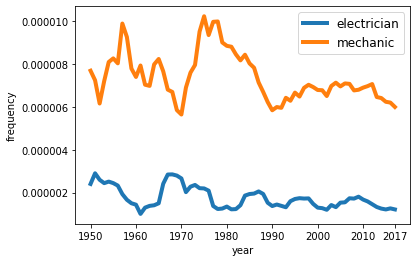

In [205]:
plot_trend('electrician','mechanic')

farmer                                            : corr = -0.63 1.11e-08 sig
fisherman                                         : corr = -0.54 2.06e-06 sig
hunter                                            : corr =  0.43 2.20e-04 sig


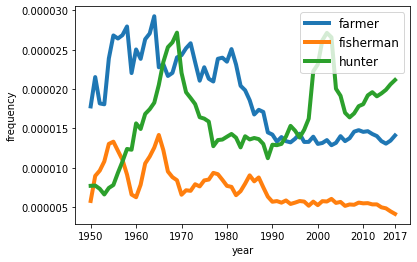

In [209]:
plot_trend('farmer','fisherman','hunter')

architect                                         : corr = -0.13 2.96e-01 
engineer                                          : corr = -0.60 7.43e-08 sig
surveyor                                          : corr = -0.45 1.06e-04 sig


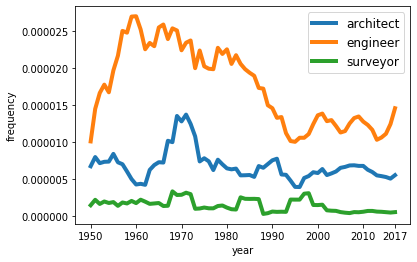

In [212]:
plot_trend('architect','engineer','surveyor')

retailer                                          : corr =  0.50 1.41e-05 sig
distributor                                       : corr =  0.44 1.49e-04 sig
vendor                                            : corr =  0.33 5.45e-03 sig
broker                                            : corr =  0.31 1.02e-02 sig


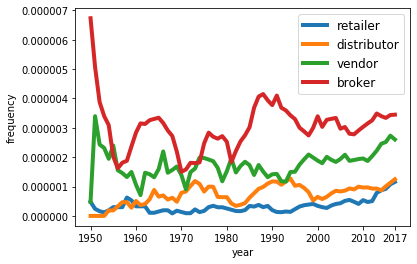

In [226]:
plot_trend('retailer','distributor','vendor','broker')

salesman                                          : corr = -0.63 7.01e-09 sig
trader                                            : corr = -0.18 1.45e-01 
grocer                                            : corr = -0.65 1.86e-09 sig
shopkeeper                                        : corr = -0.33 6.44e-03 sig


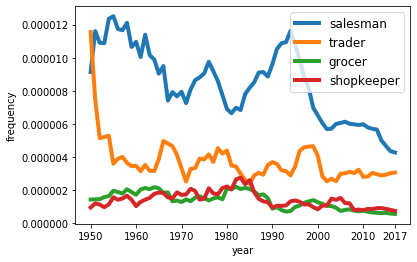

In [230]:
plot_trend('salesman','trader','grocer','shopkeeper')

estate agent                                      : corr =  0.67 4.39e-10 sig
realtor                                           : corr =  0.85 3.86e-20 sig
real estate agent                                 : corr =  0.70 3.94e-11 sig


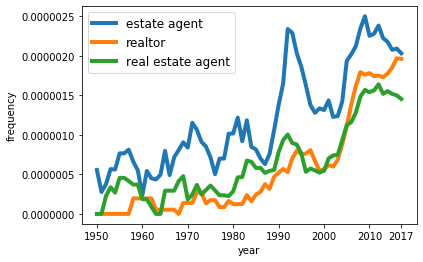

In [228]:
plot_trend('estate agent', 'realtor', 'real estate agent')

congressman                                       : corr =  0.26 3.10e-02 sig
congresswoman                                     : corr =  0.68 2.68e-10 sig


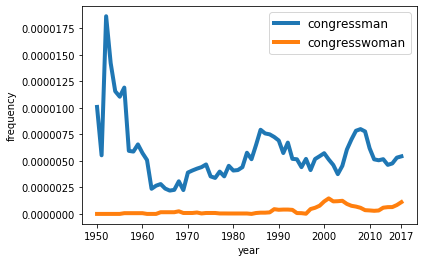

In [245]:
plot_trend('congressman','congresswoman')

congresswoman                                     : corr =  0.68 2.68e-10 sig


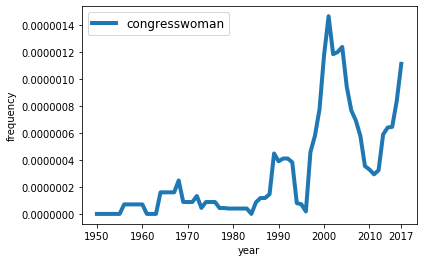

In [246]:
plot_trend('congresswoman')

headmaster                                        : corr = -0.05 7.12e-01 
headmistress                                      : corr =  0.50 1.66e-05 sig


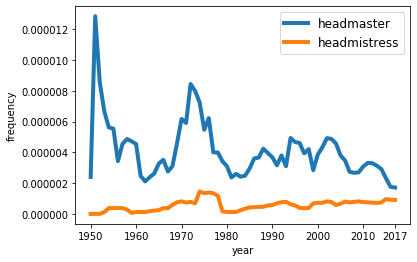

In [236]:
plot_trend('headmaster','headmistress')

alderman                                          : corr =  0.11 3.80e-01 
governor                                          : corr = -0.61 3.99e-08 sig
chancellor                                        : corr =  0.04 7.48e-01 
mayor                                             : corr =  0.10 4.38e-01 


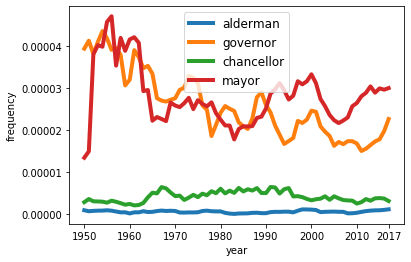

In [251]:
plot_trend('alderman','governor','chancellor','mayor')

congressman                                       : corr =  0.26 3.10e-02 sig
senator                                           : corr =  0.09 4.73e-01 
governor                                          : corr = -0.61 3.99e-08 sig
mayor                                             : corr =  0.10 4.38e-01 
congresswoman                                     : corr =  0.68 2.68e-10 sig


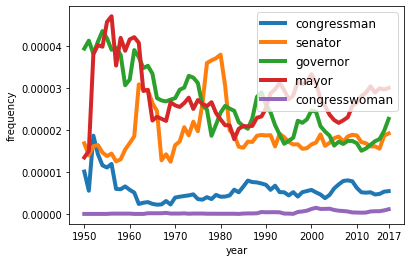

In [258]:
plot_trend('congressman','senator','governor','mayor','congresswoman')

teacher                                           : corr =  0.26 3.20e-02 sig
professor                                         : corr = -0.85 2.07e-20 sig
curator                                           : corr =  0.25 4.18e-02 sig


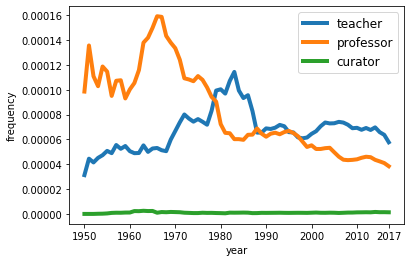

In [299]:
plot_trend('teacher','professor')

miner                                             : corr = -0.32 7.62e-03 sig
carpenter                                         : corr = -0.46 9.61e-05 sig
mason                                             : corr = -0.05 7.09e-01 


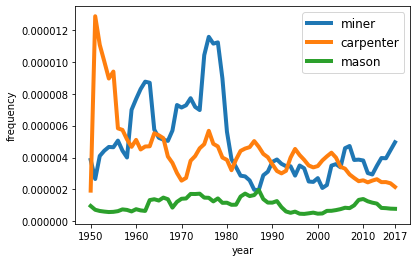

In [307]:
plot_trend('miner','carpenter','mason')

priest                                            : corr = -0.68 1.63e-10 sig
priestess                                         : corr = -0.23 6.40e-02 
monk                                              : corr = -0.11 3.53e-01 
nun                                               : corr = -0.17 1.57e-01 


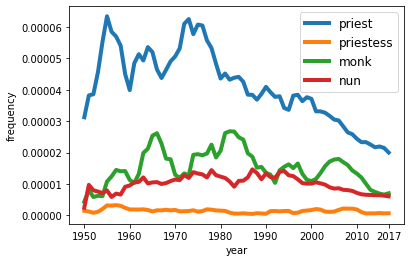

In [317]:
plot_trend('priest','priestess','monk','nun')

bishop                                            : corr = -0.37 1.75e-03 sig
pastor                                            : corr =  0.41 4.36e-04 sig
reverend                                          : corr = -0.30 1.44e-02 sig
deacon                                            : corr =  0.34 4.94e-03 sig


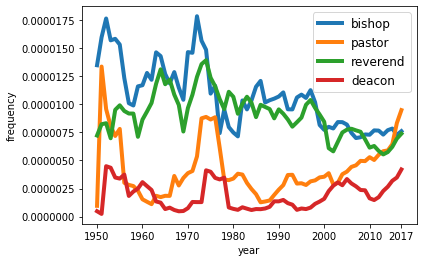

In [327]:
plot_trend('bishop','pastor','reverend','deacon')

imam                                              : corr =  0.67 3.59e-10 sig
lama                                              : corr =  0.45 1.30e-04 sig
rabbi                                             : corr =  0.40 8.49e-04 sig


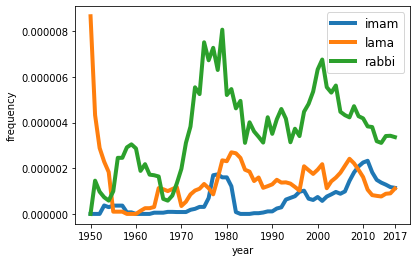

In [318]:
plot_trend('imam','lama','rabbi')

74554

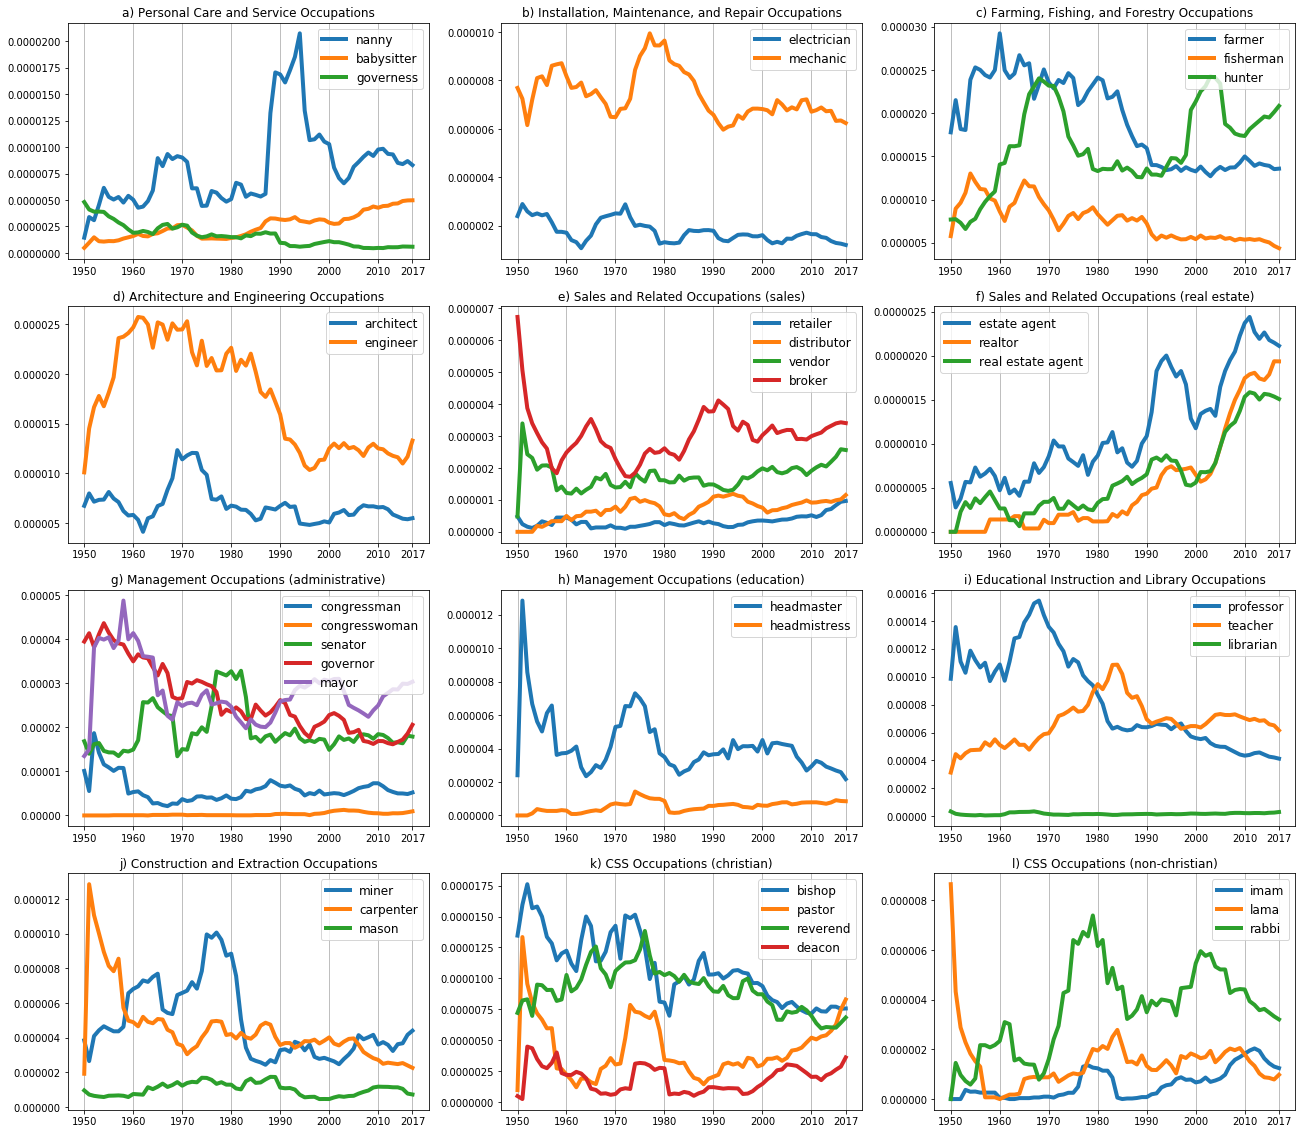

In [77]:
plt.close('all')
years = np.arange(1950, 2018).astype(str)

def helper_plot(*professions):
    for profession in professions:
        freq = profession_frequency_df.loc[profession, years].rolling(window=7, min_periods=1).mean()
        plt.plot(years.astype(int), freq, lw=4, label=profession)
    plt.xticks(ticks=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2017], labels=['1950','1960','1970','1980','1990','2000','2010','2017'])
    plt.grid(axis='x')
    plt.legend(prop={"size":12})

plt.figure(figsize=(22,20))
    
plt.subplot(4,3,1)
helper_plot('nanny','babysitter','governess')
plt.title('a) Personal Care and Service Occupations')
    
plt.subplot(4,3,2)
helper_plot('electrician','mechanic')
plt.title('b) Installation, Maintenance, and Repair Occupations')

plt.subplot(4,3,3)
helper_plot('farmer','fisherman','hunter')
plt.title('c) Farming, Fishing, and Forestry Occupations')

plt.subplot(4,3,4)
helper_plot('architect','engineer')
plt.title('d) Architecture and Engineering Occupations')

plt.subplot(4,3,5)
helper_plot('retailer','distributor','vendor','broker')
plt.title('e) Sales and Related Occupations (sales)')

plt.subplot(4,3,6)
helper_plot('estate agent', 'realtor', 'real estate agent')
plt.title('f) Sales and Related Occupations (real estate)')

plt.subplot(4,3,7)
helper_plot('congressman','congresswoman', 'senator', 'governor', 'mayor')
plt.title('g) Management Occupations (administrative)')

plt.subplot(4,3,8)
helper_plot('headmaster','headmistress')
plt.title('h) Management Occupations (education)')

plt.subplot(4,3,9)
helper_plot('professor','teacher','librarian')
plt.title('i) Educational Instruction and Library Occupations')

plt.subplot(4,3,10)
helper_plot('miner','carpenter','mason')
plt.title('j) Construction and Extraction Occupations')

plt.subplot(4,3,11)
helper_plot('bishop','pastor','reverend','deacon')
plt.title('k) CSS Occupations (christian)')

plt.subplot(4,3,12)
helper_plot('imam','lama','rabbi')
plt.title('l) CSS Occupations (non-christian)')

tikzplotlib.save('data/analysis_data/profession_trend_II.tex')
content = open('data/analysis_data/profession_trend_II.tex').read()
content = content.replace('begin{tikzpicture}','begin{tikzpicture}[scale=0.6]')
mobj = re.search('begin{groupplot}[^}]+', content)
_, j = mobj.span()
content = content[:j] + ', horizontal sep=2.5cm, vertical sep=2.5cm' + content[j:]
content = content.replace('nextgroupplot[','nextgroupplot[\n/pgf/number format/1000 sep={},\ntitle style={below, at={(0.5,-0.15)}},\nticklabel style={font=\scriptsize},')
open('data/analysis_data/profession_trend_II.tex','w').write(content)
# plt.show()

cardiologist                                      : corr =  0.74 7.33e-13 sig
chiropractor                                      : corr =  0.60 7.55e-08 sig
gynecologist                                      : corr =  0.52 4.42e-06 sig
neurologist                                       : corr =  0.73 1.17e-12 sig


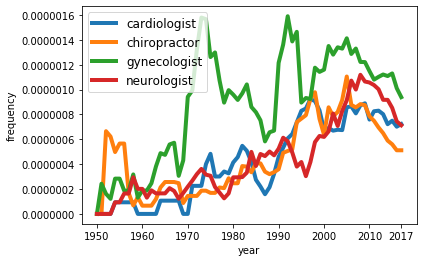

In [337]:
plot_trend('cardiologist','chiropractor','gynecologist','neurologist')

doctor                                            : corr = -0.83 4.79e-18 sig
physician                                         : corr = -0.31 1.02e-02 sig


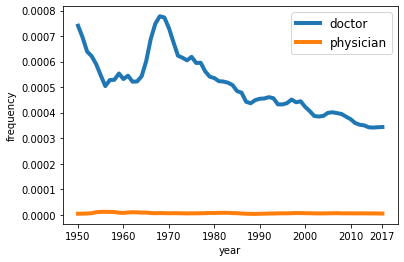

In [356]:
plot_trend('doctor','physician')

physician                                         : corr = -0.31 1.02e-02 sig


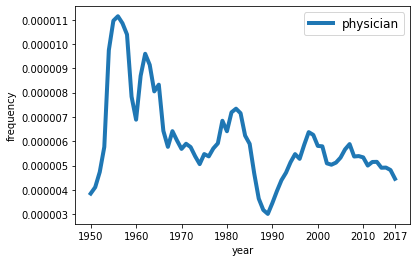

In [355]:
plot_trend('physician')

policeman                                         : corr = -0.76 5.57e-14 sig
policewoman                                       : corr =  0.01 9.58e-01 


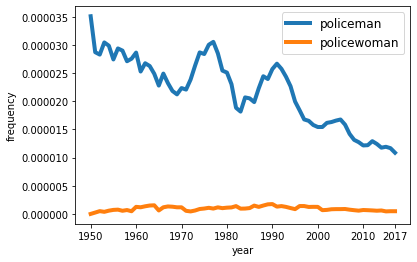

In [41]:
plot_trend('policeman', 'policewoman')

bodyguard                                         : corr =  0.36 2.50e-03 sig
prison guard                                      : corr =  0.44 1.79e-04 sig
security guard                                    : corr =  0.82 7.07e-18 sig


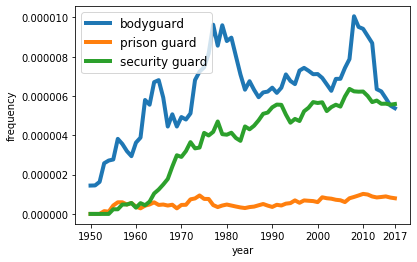

In [45]:
plot_trend('bodyguard','prison guard', 'security guard')

jeweller                                          : corr = -0.62 2.06e-08 sig
shoemaker                                         : corr = -0.45 1.10e-04 sig
tailor                                            : corr = -0.78 6.63e-15 sig


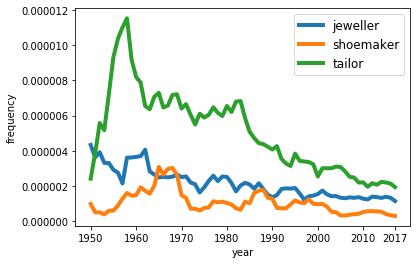

In [52]:
plot_trend('jeweller','shoemaker','tailor')

flight attendant                                  : corr =  0.86 1.46e-20 sig
steward                                           : corr = -0.73 1.38e-12 sig
stewardess                                        : corr = -0.29 1.70e-02 sig


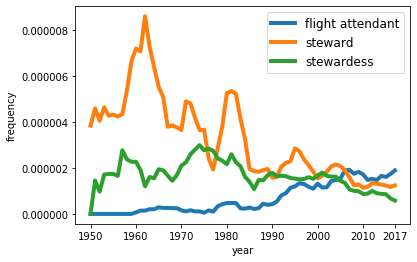

In [10]:
plot_trend('flight attendant','steward','stewardess')

bus driver                                        : corr =  0.26 3.17e-02 sig
cab driver                                        : corr =  0.00 9.70e-01 
truck driver                                      : corr = -0.27 2.38e-02 sig


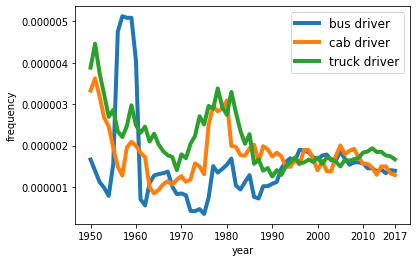

In [11]:
plot_trend('bus driver','cab driver','truck driver')

sailor                                            : corr = -0.86 5.76e-21 sig
pilot                                             : corr = -0.17 1.62e-01 


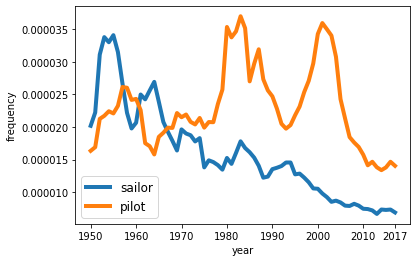

In [12]:
plot_trend('sailor','pilot')

clerk                                             : corr = -0.86 9.56e-21 sig
secretary                                         : corr = -0.66 1.34e-09 sig
bookkeeper                                        : corr = -0.61 2.80e-08 sig


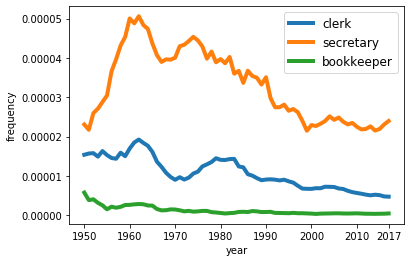

In [20]:
plot_trend('clerk','secretary','bookkeeper')

field marshal                                     : corr = -0.44 1.62e-04 sig
admiral                                           : corr = -0.48 3.39e-05 sig
air marshal                                       : corr =  0.47 6.44e-05 sig


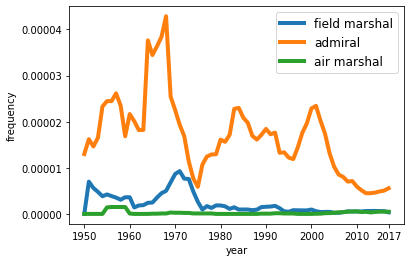

In [62]:
plot_trend('field marshal','admiral','air marshal')

field marshal                                     : corr = -0.44 1.62e-04 sig
admiral                                           : corr = -0.48 3.39e-05 sig
air marshal                                       : corr =  0.47 6.44e-05 sig


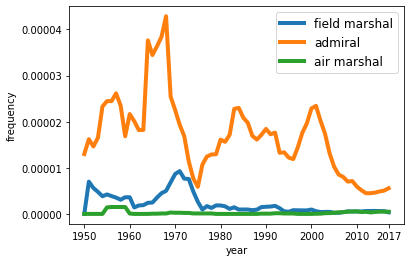

In [64]:
plot_trend('field marshal','admiral','air marshal')

navy seal                                         : corr =  0.83 2.53e-18 sig


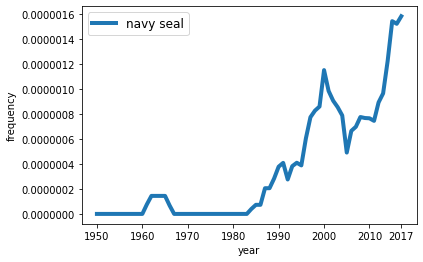

In [30]:
plot_trend('navy seal')

soldier                                           : corr = -0.86 7.04e-21 sig
corporal                                          : corr = -0.82 1.40e-17 sig


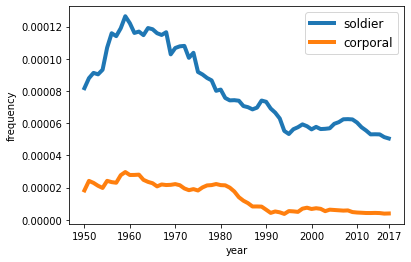

In [51]:
plot_trend('soldier','corporal')

sweeper                                           : corr = -0.09 4.87e-01 
caretaker                                         : corr = -0.20 1.03e-01 
gardener                                          : corr = -0.45 1.01e-04 sig


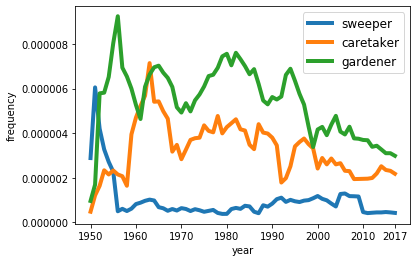

In [71]:
plot_trend('sweeper','caretaker', 'gardener')

accountant                                        : corr = -0.22 6.91e-02 
auditor                                           : corr =  0.02 8.54e-01 


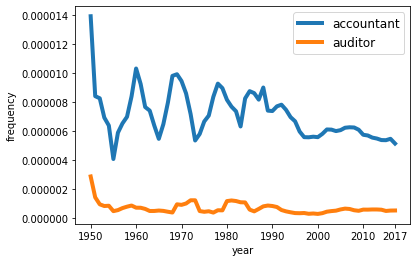

In [75]:
plot_trend('accountant','auditor')

60708

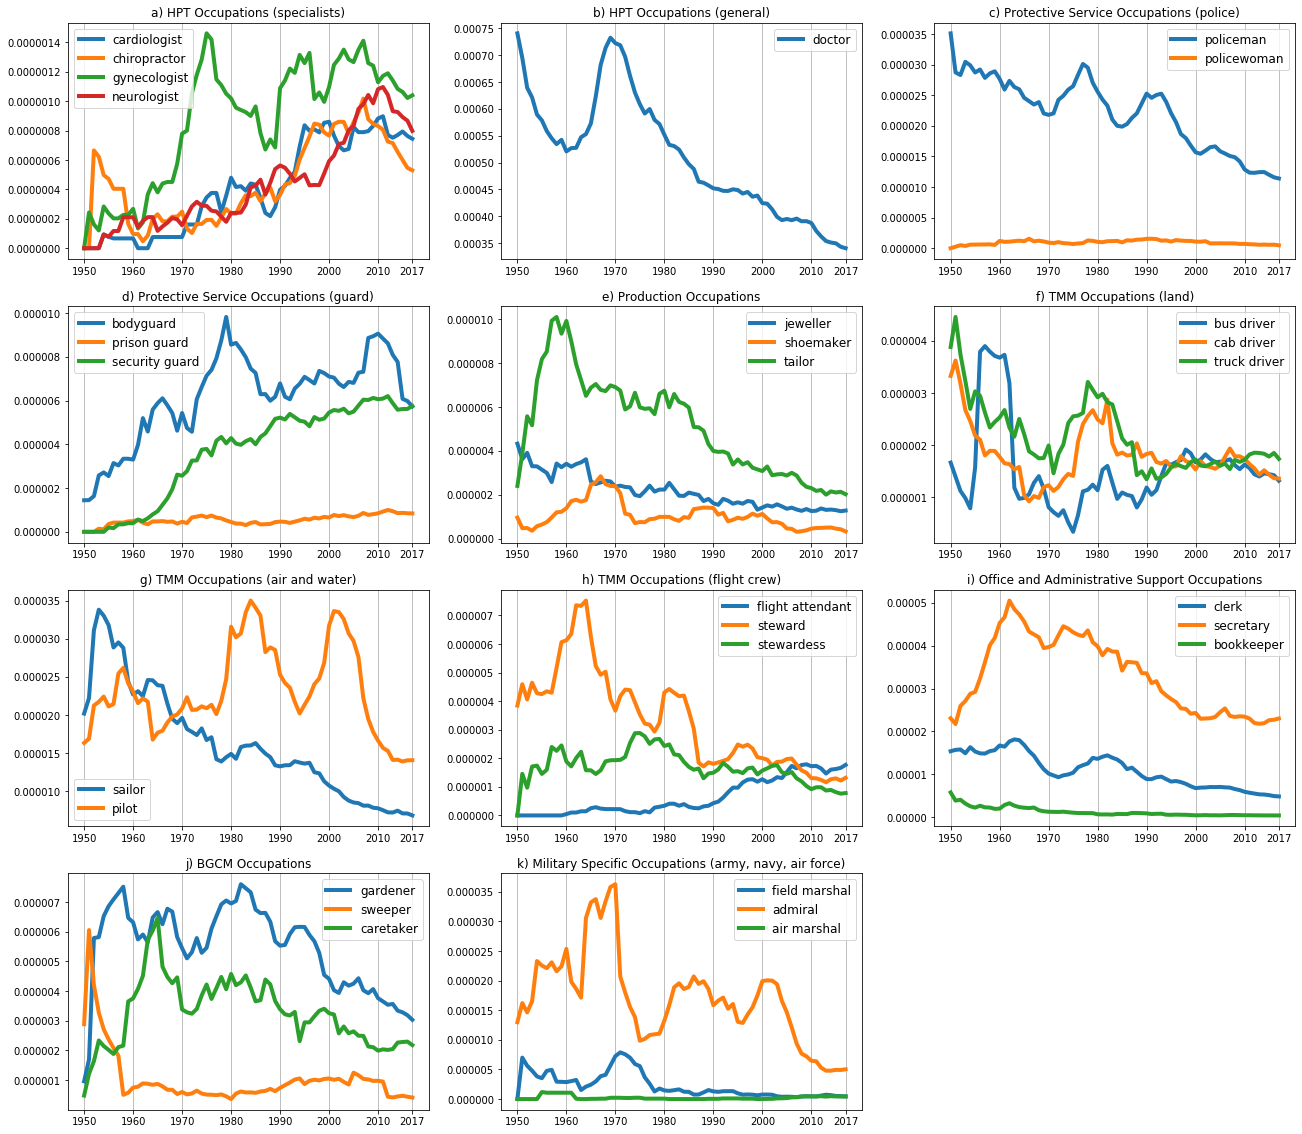

In [79]:
plt.close('all')
years = np.arange(1950, 2018).astype(str)

def helper_plot(*professions):
    for profession in professions:
        if profession in profession_frequency_df.index:
            freq = profession_frequency_df.loc[profession, years].rolling(window=7, min_periods=1).mean()
        else:
            freq = find_frequecy_by_individual_profession(profession).rolling(window=7, min_periods=1).mean()
        plt.plot(years.astype(int), freq, lw=4, label=profession)
    plt.xticks(ticks=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2017], labels=['1950','1960','1970','1980','1990','2000','2010','2017'])
    plt.grid(axis='x')
    plt.legend(prop={"size":12})

plt.figure(figsize=(22,20))

plt.subplot(4,3,1)
helper_plot('cardiologist','chiropractor','gynecologist','neurologist')
plt.title('a) HPT Occupations (specialists)')

plt.subplot(4,3,2)
helper_plot('doctor')
plt.title('b) HPT Occupations (general)')

plt.subplot(4,3,3)
helper_plot('policeman', 'policewoman')
plt.title('c) Protective Service Occupations (police)')

plt.subplot(4,3,4)
helper_plot('bodyguard','prison guard', 'security guard')
plt.title('d) Protective Service Occupations (guard)')

plt.subplot(4,3,5)
helper_plot('jeweller','shoemaker','tailor')
plt.title('e) Production Occupations')

plt.subplot(4,3,6)
helper_plot('bus driver','cab driver','truck driver')
plt.title('f) TMM Occupations (land)')

plt.subplot(4,3,7)
helper_plot('sailor','pilot')
plt.title('g) TMM Occupations (air and water)')

plt.subplot(4,3,8)
helper_plot('flight attendant','steward','stewardess')
plt.title('h) TMM Occupations (flight crew)')

plt.subplot(4,3,9)
helper_plot('clerk','secretary','bookkeeper')
plt.title('i) Office and Administrative Support Occupations')

plt.subplot(4,3,10)
helper_plot('gardener','sweeper','caretaker')
plt.title('j) BGCM Occupations')

plt.subplot(4,3,11)
helper_plot('field marshal','admiral','air marshal')
plt.title('k) Military Specific Occupations (army, navy, air force)')

tikzplotlib.save('data/analysis_data/profession_trend_III.tex')
content = open('data/analysis_data/profession_trend_III.tex').read()
content = content.replace('begin{tikzpicture}','begin{tikzpicture}[scale=0.6]')
mobj = re.search('begin{groupplot}[^}]+', content)
_, j = mobj.span()
content = content[:j] + ', horizontal sep=2.5cm, vertical sep=2.5cm' + content[j:]
content = content.replace('nextgroupplot[','nextgroupplot[\n/pgf/number format/1000 sep={},\ntitle style={below, at={(0.5,-0.15)}},\nticklabel style={font=\scriptsize},')
open('data/analysis_data/profession_trend_III.tex','w').write(content)
# plt.show()

In [32]:
mi = profession_frequency_df.loc['doctor', years].rolling(window=7, min_periods=1).mean().min()
ma = profession_frequency_df.loc['doctor', years].rolling(window=7, min_periods=1).mean().max()
print(f"min = {mi:5.2e}, ma = {ma:5.2e}")

mi = profession_frequency_df.loc['physician', years].rolling(window=7, min_periods=1).mean().min()
ma = profession_frequency_df.loc['physician', years].rolling(window=7, min_periods=1).mean().max()
print(f"min = {mi:5.2e}, ma = {ma:5.2e}")

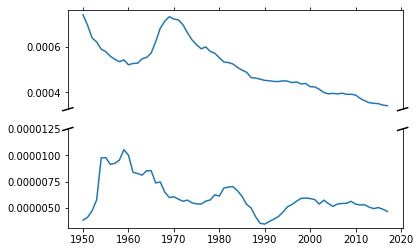

In [33]:
plt.close('all')
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
ax.plot(years.astype(int), profession_frequency_df.loc['doctor', years].rolling(window=7, min_periods=1).mean())
ax2.plot(years.astype(int), profession_frequency_df.loc['physician', years].rolling(window=7, min_periods=1).mean())
ax.set_ylim(bottom=3.25e-4)
ax2.set_ylim(top=1.25e-5)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .015

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.show()

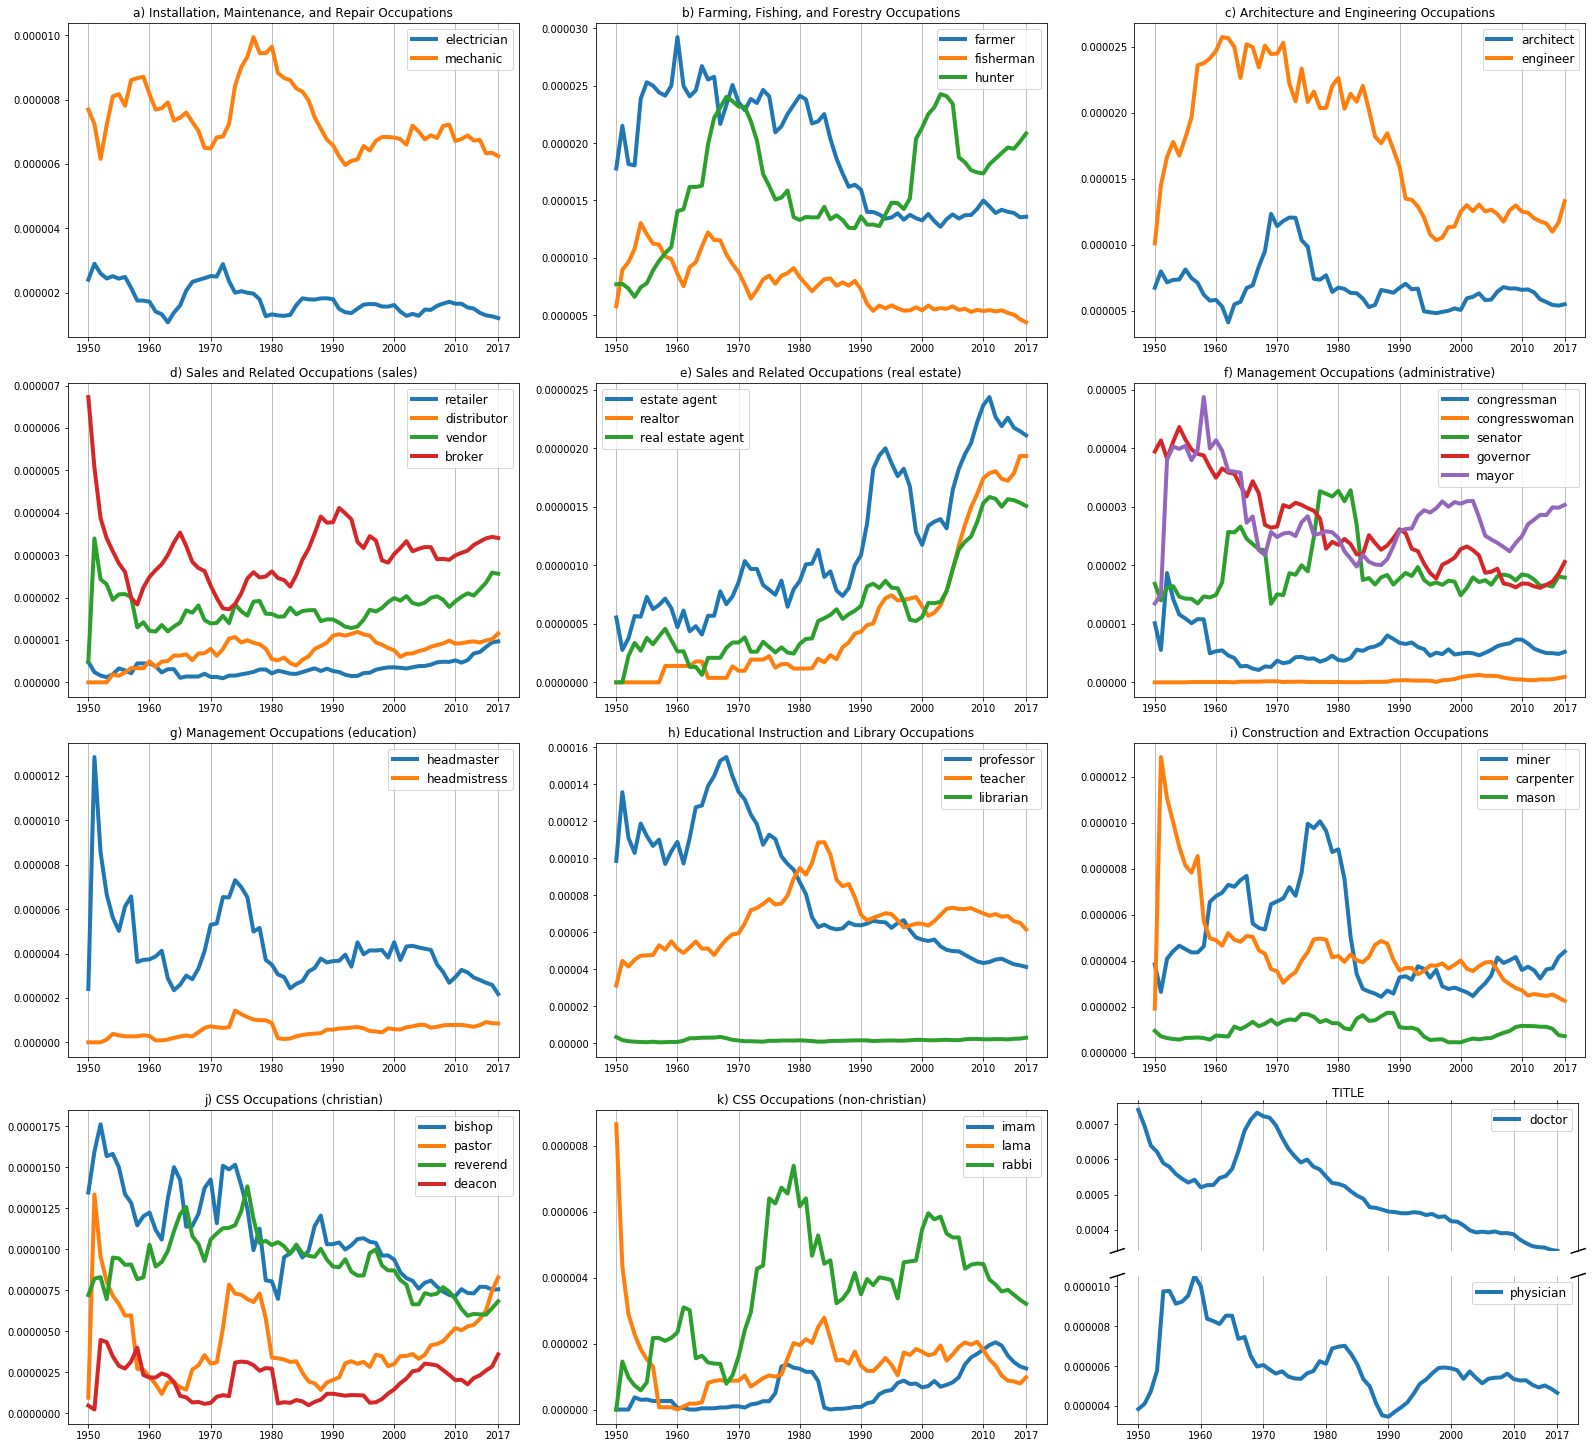

In [38]:
plt.close('all')
years = np.arange(1950, 2018).astype(str)
fig = plt.figure(figsize=(22,20), constrained_layout=True)
gs = fig.add_gridspec(4,3)

def spec_helper_plot(axis, *professions):
    for profession in professions:
        freq = profession_frequency_df.loc[profession, years].rolling(window=7, min_periods=1).mean()
        axis.plot(years.astype(int), freq, lw=4, label=profession)
    axis.set_xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2017])
    axis.set_xticklabels(['1950','1960','1970','1980','1990','2000','2010','2017'])
    axis.grid(True, axis='x')
    axis.legend(prop={"size":12})
    
def spec_helper_plot_break(fig, gs, upper_professions, lower_professions, title):
    upper_freqs = [profession_frequency_df.loc[pf, years].rolling(window=7, min_periods=1).mean() for pf in upper_professions]
    lower_freqs = [profession_frequency_df.loc[pf, years].rolling(window=7, min_periods=1).mean() for pf in lower_professions]
    
    upper_min = min([np.min(freq) for freq in upper_freqs])
    lower_max = max([np.max(freq) for freq in lower_freqs])
    
    igs = gs.subgridspec(2,1)
    upper_axis = fig.add_subplot(igs[0,0])
    lower_axis = fig.add_subplot(igs[1,0])
    
    for profession, freq in zip(upper_professions, upper_freqs):
        upper_axis.plot(years.astype(int), freq, lw=4, label=profession)
        
    for profession, freq in zip(lower_professions, lower_freqs):
        lower_axis.plot(years.astype(int), freq, lw=4, label=profession)
        
    upper_axis.set_xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2017])
    upper_axis.set_xticklabels(['1950','1960','1970','1980','1990','2000','2010','2017'])
    upper_axis.grid(True, axis='x')
    upper_axis.legend(prop={"size":12})
    
    lower_axis.set_xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2017])
    lower_axis.set_xticklabels(['1950','1960','1970','1980','1990','2000','2010','2017'])
    lower_axis.grid(True, axis='x')
    lower_axis.legend(prop={"size":12})
    
    upper_axis.set_ylim(bottom=upper_min)
    lower_axis.set_ylim(top=lower_max)
    
    lower_axis.spines['top'].set_visible(False)
    upper_axis.spines['bottom'].set_visible(False)
    upper_axis.xaxis.tick_top()
    upper_axis.tick_params(labeltop=False)
    lower_axis.xaxis.tick_bottom()

    d = .015

    kwargs = dict(transform=upper_axis.transAxes, color='k', clip_on=False)
    upper_axis.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    upper_axis.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=lower_axis.transAxes)  # switch to the bottom axes
    lower_axis.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    lower_axis.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    upper_axis.set_title(title)
    
axis = fig.add_subplot(gs[0,0])
spec_helper_plot(axis, 'electrician','mechanic')
axis.set_title('a) Installation, Maintenance, and Repair Occupations')

axis = fig.add_subplot(gs[0,1])
spec_helper_plot(axis, 'farmer','fisherman','hunter')
axis.set_title('b) Farming, Fishing, and Forestry Occupations')

axis = fig.add_subplot(gs[0,2])
spec_helper_plot(axis, 'architect','engineer')
axis.set_title('c) Architecture and Engineering Occupations')

axis = fig.add_subplot(gs[1,0])
spec_helper_plot(axis, 'retailer','distributor','vendor','broker')
axis.set_title('d) Sales and Related Occupations (sales)')

axis = fig.add_subplot(gs[1,1])
spec_helper_plot(axis, 'estate agent', 'realtor', 'real estate agent')
axis.set_title('e) Sales and Related Occupations (real estate)')

axis = fig.add_subplot(gs[1,2])
spec_helper_plot(axis, 'congressman','congresswoman', 'senator', 'governor', 'mayor')
axis.set_title('f) Management Occupations (administrative)')

axis = fig.add_subplot(gs[2,0])
spec_helper_plot(axis, 'headmaster','headmistress')
axis.set_title('g) Management Occupations (education)')

axis = fig.add_subplot(gs[2,1])
spec_helper_plot(axis, 'professor','teacher','librarian')
axis.set_title('h) Educational Instruction and Library Occupations')

axis = fig.add_subplot(gs[2,2])
spec_helper_plot(axis, 'miner','carpenter','mason')
axis.set_title('i) Construction and Extraction Occupations')

axis = fig.add_subplot(gs[3,0])
spec_helper_plot(axis, 'bishop','pastor','reverend','deacon')
axis.set_title('j) CSS Occupations (christian)')

axis = fig.add_subplot(gs[3,1])
spec_helper_plot(axis, 'imam','lama','rabbi')
axis.set_title('k) CSS Occupations (non-christian)')

spec_helper_plot_break(fig, gs[3,2], ['doctor'], ['physician'], 'TITLE')

tikzplotlib.save('data/analysis_data/profession_trend_IV.tex')

In [33]:
professions = mentions_df.profession_merge.unique()

In [34]:
for profession in professions:
    if re.search("(^|\s)air($|\s)", profession):
        print(profession)

air force officer
air hostess
air marshal


In [35]:
mentions_df.profession_merge.unique().size

4073

In [46]:
find_frequecy_by_individual_profession('air marshal')

array([ 0.,  0.,  0.,  0.,  0., 18.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  4.,  0.,  0.,  0.,  0.,  2.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        2.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,
        1., 10.,  2.,  6., 22.,  6., 31.,  7., 16.,  7., 22., 19., 32.,
       38.,  6., 11.])

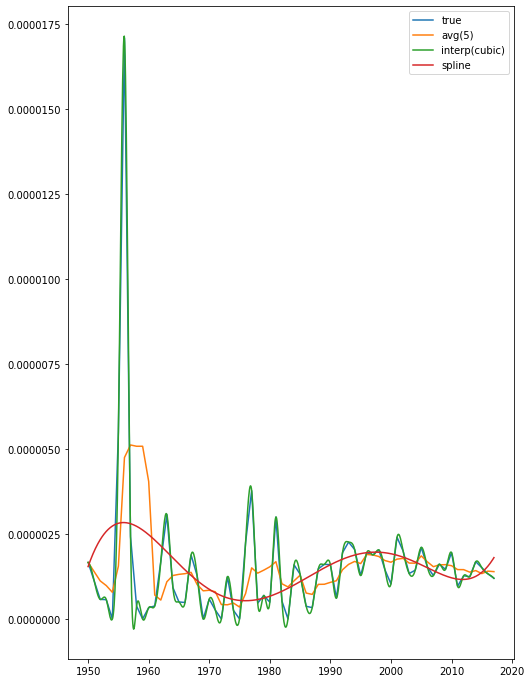

In [101]:
x = years.astype(int)
xn = np.linspace(1950, 2017, num=1000, endpoint=True)

y = profession_frequency_df.loc['bus driver', years].values
y1 = profession_frequency_df.loc['bus driver', years].rolling(window=5, min_periods=1).mean()
f1 = interp1d(x,y,kind='cubic')
y2 = f1(xn)
f2 = splrep(x, y, w=np.ones(len(x)), k=5)
y3 = splev(xn, f2)

plt.figure(figsize=(8, 12))

plt.plot(x, y, label='true')
plt.plot(x, y1, label='avg(5)')
plt.plot(xn, y2, label='interp(cubic)')
plt.plot(xn, y3, label='spline')

plt.legend()
plt.show()